# 88Sr⁺ Pulse Sequence Demo

This notebook loads Sr⁺ pulse sequences from JSON, performs quick sanity checks,
and plots timelines for:
- **State Preparation + Measurement**
- **Sideband Cooling (timescan)**

Focus: clear mapping from **experimental intent** → **channels over time**.


In [1]:
# Project imports (assumes this notebook is one level below package root)
import sys, os, json, math
from pathlib import Path

#sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

# Package pieces
from pulse_sequence_generator.core import Sequence  # must provide Sequence.from_dict(...) and .plot(...)
from pulse_sequence_generator.config import RC_PARAMS
import matplotlib as mpl
import matplotlib.pyplot as plt


## Context: channels and roles

- **AOM 422 σ−**: optical pumping to prepare |↓⟩.  
- **AOM 422**: detection beam (cycling), optionally detuned block.  
- **AOM 674**: narrow 674 nm quadrupole drive (π/sideband pulses).  
- **AOM 1092**: repump from D-states.  
- **PMT**: detection gate (counts only during this window).

We’ll inspect sequences to ensure channels and durations match the intended protocol.


In [2]:
def plot_pulse_sequence(json_input: str, *, from_string: bool = False, rc_params: dict | None = None):
    """Load a pulse sequence from JSON (file path or JSON string) and plot it.

    Args:
        json_input: Path to a JSON file, or a raw JSON string if `from_string=True`.
        from_string: Treat `json_input` as the JSON content string if True.
        rc_params: Optional Matplotlib rcParams to apply before plotting.

    Returns:
        (fig, ax): Matplotlib Figure and Axes with the rendered sequence.

    Raises:
        RuntimeError: If loading or parsing fails, or if Sequence.from_dict is missing.
    """
    if rc_params:
        plt.rcParams.update(rc_params)

    try:
        data = json.loads(json_input) if from_string else json.loads(Path(json_input).read_text(encoding="utf-8"))
    except Exception as e:
        raise RuntimeError(f"Failed to load JSON input: {e}")

    try:
        seq = Sequence.from_dict(data)
    except AttributeError as e:
        raise RuntimeError("Sequence.from_dict constructor not found on Sequence") from e
    except Exception as e:
        raise RuntimeError(f"Failed to build Sequence from JSON: {e}") from e

    labels = data.get("labels", [])
    title  = data.get("title", None)

    fig, ax = seq.plot(labels=labels, title=title)
    fig.tight_layout()
    plt.show()
    plt.close(fig)
    return fig, ax


In [3]:
from pathlib import Path

BASE_DIR = Path(__file__).parent if '__file__' in globals() else Path.cwd()
DATA_DIR = BASE_DIR / "pulse_sequence_generator" / "data"
STATEPREP_FILE = DATA_DIR / "StatePrepDetect.json"
SIDEBAND_FILE  = DATA_DIR / "Sideband.json"


# Optional: tweak rcParams globally
plt.rcParams.update(RC_PARAMS)


## State Preparation + Measurement

- **422 σ− on** then **674** pulse for spin/transition control as needed.  
- **PMT gate** active only during the detection window.  
- **1092** repump spans the entire cycle to empty D-states.  
- Final **422** block may be detuned (as shown in label) after detection.


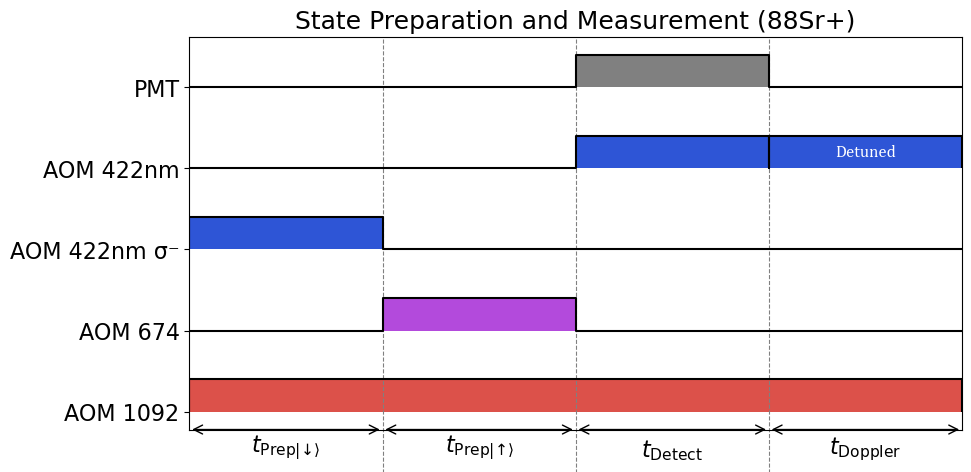

(<Figure size 1000x500 with 1 Axes>,
 <Axes: title={'center': 'State Preparation and Measurement (88Sr+)'}>)

In [4]:

plot_pulse_sequence(str(STATEPREP_FILE))


## Sideband Cooling (Timescan)

Sequence adds a **674 sideband pulse** block; earlier segments prepare the ion,
then the sideband pulse duration is scanned. Detection mirrors state-prep case.


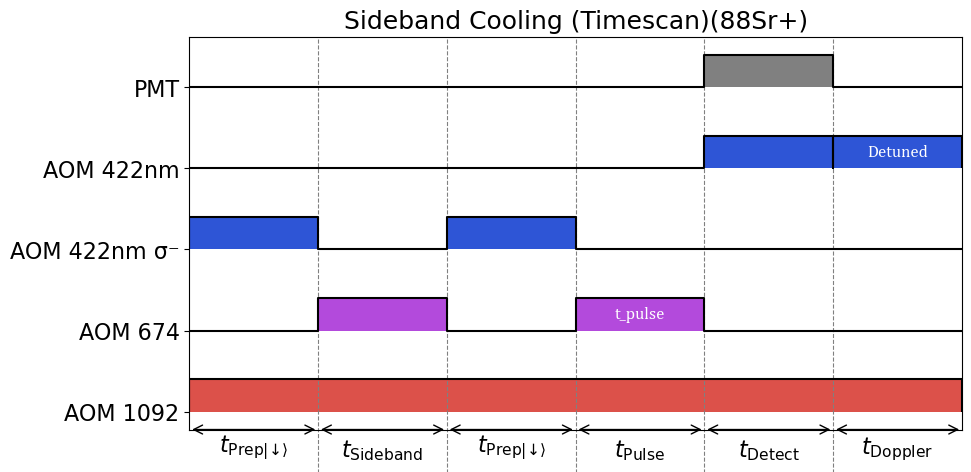

(<Figure size 1000x500 with 1 Axes>,
 <Axes: title={'center': 'Sideband Cooling (Timescan)(88Sr+)'}>)

In [5]:

plot_pulse_sequence(str(SIDEBAND_FILE))


In [6]:
# OUT = Path("figs"); OUT.mkdir(exist_ok=True)
# for name, path in [("stateprep_detect", STATEPREP_FILE), ("sideband_cooling", SIDEBAND_FILE)]:
#     fig, ax = plot_pulse_sequence(str(path))  # returns fig, ax
#     fig.savefig(OUT / f"{name}.png", dpi=300, bbox_inches="tight")
#     plt.close(fig)
# print("Saved to:", OUT.resolve())
